In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")
ratings2 = pd.read_pickle("./Data/small_random_selection_longform_2.pkl")
user_stats = pd.read_pickle("./Data/moderate_user_stats.pkl")

In [4]:
ratings = pd.concat([ratings, ratings2])

In [6]:
ratings.drop(index=ratings[ratings.duplicated(keep='first')].index, inplace=True)

In [7]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(44012, 37296)

In [8]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [11]:
# HP_NUM_UNITS = [32, 128]
# HP_DROPOUT = [.3, .4]
# HP_LEARNING_RATE = [.01, .1]
# HP_REGULARIZER = ['l2']
# HP_EMBEDDING = [15]
HP_BATCH_NORMAL = [.1, .01, .001]

In [9]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    dense1 = keras.layers.Dense(128, 
                           activation='relu', 
                           kernel_regularizer='l2')(conc_layer)
    
#     dropout = x = keras.layers.Dropout(rate=.3, seed=42)(x)
    
    normalizer = keras.layers.BatchNormalization(epsilon=hparams['HP_BATCH_NORMAL'])(dense1)
    
    dense2 = keras.layers.Dense(32, 
                           activation='relu', 
                           kernel_regularizer='l2')(normalizer)
    
    dropout1 = keras.layers.Dropout(rate=.4, seed=42)(dense2)
    
    dense3 = keras.layers.Dense(32, 
                           activation='relu', 
                           kernel_regularizer='l2')(dropout1)
    
    x_out = keras.layers.Dense(1, 
                               activation='relu',
                              kernel_regularizer='l2')(dense3)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=.01)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

#     print(hist.history['val_mean_squared_error'])
    return hist, model

In [12]:
run_history = {}
models = []

session_num = 0


for epsilon in HP_BATCH_NORMAL:

    hparams = {
    'HP_BATCH_NORMAL': epsilon,
    }

    run_name = "run-{}".format(session_num)
    print("----Starting trial: {}".format(run_name))
    print(hparams)

    output, model = train_test_model(hparams,)
    run_history[run_name] = {
        'params': hparams,
        'output': output,
    }
    models.append(model)
    session_num += 1

----Starting trial: run-0
{'HP_BATCH_NORMAL': 0.1}
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 16.3692 - root_mean_squared_error: 3.8769 - val_loss: 15.1593 - val_root_mean_squared_error: 3.7258
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 14.2724 - root_mean_squared_error: 3.6049 - val_loss: 12.7150 - val_root_mean_squared_error: 3.3849
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 11.2187 - root_mean_squared_error: 3.1561 - val_loss: 9.2971 - val_root_mean_squared_error: 2.8347
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 7.3917 - root_mean_squared_error: 2.4759 - val_loss: 5.3134 - val_root_mean_squared_error: 2.0077
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 3.9879 - root_mean_squared_error: 1.6448 - val_loss: 2.4872 - val_root_mean_squared_error: 1.0853
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 3.9546 - root_mean_squared_error: 

1/1 [==============================] - 2s 2s/step - loss: 1.2741 - root_mean_squared_error: 0.9061 - val_loss: 1.3925 - val_root_mean_squared_error: 0.9742
Epoch 50/100
1/1 [==============================] - 2s 2s/step - loss: 1.2566 - root_mean_squared_error: 0.9018 - val_loss: 1.3622 - val_root_mean_squared_error: 0.9631
Epoch 51/100
1/1 [==============================] - 2s 2s/step - loss: 1.2362 - root_mean_squared_error: 0.8953 - val_loss: 1.3274 - val_root_mean_squared_error: 0.9492
Epoch 52/100
1/1 [==============================] - 2s 2s/step - loss: 1.2210 - root_mean_squared_error: 0.8914 - val_loss: 1.2993 - val_root_mean_squared_error: 0.9385
Epoch 53/100
1/1 [==============================] - 2s 2s/step - loss: 1.2074 - root_mean_squared_error: 0.8882 - val_loss: 1.2827 - val_root_mean_squared_error: 0.9339
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 1.1964 - root_mean_squared_error: 0.8865 - val_loss: 1.2771 - val_root_mean_squared_error: 0.9353

1/1 [==============================] - 2s 2s/step - loss: 0.8597 - root_mean_squared_error: 0.7945 - val_loss: 1.0769 - val_root_mean_squared_error: 0.9222
Epoch 98/100
1/1 [==============================] - 2s 2s/step - loss: 0.8558 - root_mean_squared_error: 0.7933 - val_loss: 1.0754 - val_root_mean_squared_error: 0.9224
Epoch 99/100
1/1 [==============================] - 2s 2s/step - loss: 0.8515 - root_mean_squared_error: 0.7918 - val_loss: 1.0718 - val_root_mean_squared_error: 0.9215
Epoch 100/100
1/1 [==============================] - 2s 2s/step - loss: 0.8463 - root_mean_squared_error: 0.7897 - val_loss: 1.0669 - val_root_mean_squared_error: 0.9197
----Starting trial: run-1
{'HP_BATCH_NORMAL': 0.01}
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 15.7917 - root_mean_squared_error: 3.7974 - val_loss: 15.1810 - val_root_mean_squared_error: 3.7166
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 12.1802 - root_mean_squared_error: 3.2883 - 

1/1 [==============================] - 2s 2s/step - loss: 1.3568 - root_mean_squared_error: 0.8802 - val_loss: 1.7767 - val_root_mean_squared_error: 1.0997
Epoch 46/100
1/1 [==============================] - 2s 2s/step - loss: 1.3222 - root_mean_squared_error: 0.8689 - val_loss: 1.8292 - val_root_mean_squared_error: 1.1298
Epoch 47/100
1/1 [==============================] - 2s 2s/step - loss: 1.3057 - root_mean_squared_error: 0.8677 - val_loss: 1.8277 - val_root_mean_squared_error: 1.1348
Epoch 48/100
1/1 [==============================] - 2s 2s/step - loss: 1.2958 - root_mean_squared_error: 0.8694 - val_loss: 1.7479 - val_root_mean_squared_error: 1.1039
Epoch 49/100
1/1 [==============================] - 2s 2s/step - loss: 1.2704 - root_mean_squared_error: 0.8609 - val_loss: 1.6377 - val_root_mean_squared_error: 1.0572
Epoch 50/100
1/1 [==============================] - 2s 2s/step - loss: 1.2478 - root_mean_squared_error: 0.8531 - val_loss: 1.5644 - val_root_mean_squared_error: 1.0265

1/1 [==============================] - 2s 2s/step - loss: 0.7812 - root_mean_squared_error: 0.7094 - val_loss: 1.2621 - val_root_mean_squared_error: 0.9933
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 0.7728 - root_mean_squared_error: 0.7052 - val_loss: 1.2586 - val_root_mean_squared_error: 0.9928
Epoch 95/100
1/1 [==============================] - 2s 2s/step - loss: 0.7677 - root_mean_squared_error: 0.7034 - val_loss: 1.2568 - val_root_mean_squared_error: 0.9932
Epoch 96/100
1/1 [==============================] - 2s 2s/step - loss: 0.7616 - root_mean_squared_error: 0.7009 - val_loss: 1.2527 - val_root_mean_squared_error: 0.9923
Epoch 97/100
1/1 [==============================] - 2s 2s/step - loss: 0.7546 - root_mean_squared_error: 0.6975 - val_loss: 1.2484 - val_root_mean_squared_error: 0.9913
Epoch 98/100
1/1 [==============================] - 2s 2s/step - loss: 0.7481 - root_mean_squared_error: 0.6945 - val_loss: 1.2469 - val_root_mean_squared_error: 0.9917

1/1 [==============================] - 2s 2s/step - loss: 1.4012 - root_mean_squared_error: 0.8794 - val_loss: 4.6117 - val_root_mean_squared_error: 1.9990
Epoch 42/100
1/1 [==============================] - 2s 2s/step - loss: 1.3762 - root_mean_squared_error: 0.8720 - val_loss: 4.3673 - val_root_mean_squared_error: 1.9399
Epoch 43/100
1/1 [==============================] - 2s 2s/step - loss: 1.3566 - root_mean_squared_error: 0.8676 - val_loss: 4.2085 - val_root_mean_squared_error: 1.9018
Epoch 44/100
1/1 [==============================] - 2s 2s/step - loss: 1.3356 - root_mean_squared_error: 0.8625 - val_loss: 4.1273 - val_root_mean_squared_error: 1.8837
Epoch 45/100
1/1 [==============================] - 2s 2s/step - loss: 1.3115 - root_mean_squared_error: 0.8558 - val_loss: 4.0668 - val_root_mean_squared_error: 1.8709
Epoch 46/100
1/1 [==============================] - 2s 2s/step - loss: 1.2912 - root_mean_squared_error: 0.8513 - val_loss: 3.9654 - val_root_mean_squared_error: 1.8468

1/1 [==============================] - 2s 2s/step - loss: 0.7696 - root_mean_squared_error: 0.6930 - val_loss: 1.4177 - val_root_mean_squared_error: 1.0638
Epoch 90/100
1/1 [==============================] - 2s 2s/step - loss: 0.7613 - root_mean_squared_error: 0.6894 - val_loss: 1.4071 - val_root_mean_squared_error: 1.0604
Epoch 91/100
1/1 [==============================] - 2s 2s/step - loss: 0.7541 - root_mean_squared_error: 0.6866 - val_loss: 1.3902 - val_root_mean_squared_error: 1.0539
Epoch 92/100
1/1 [==============================] - 2s 2s/step - loss: 0.7467 - root_mean_squared_error: 0.6836 - val_loss: 1.3861 - val_root_mean_squared_error: 1.0535
Epoch 93/100
1/1 [==============================] - 2s 2s/step - loss: 0.7406 - root_mean_squared_error: 0.6815 - val_loss: 1.3759 - val_root_mean_squared_error: 1.0502
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 0.7328 - root_mean_squared_error: 0.6781 - val_loss: 1.3620 - val_root_mean_squared_error: 1.0450

In [18]:
model.save('saved_model/copy12/model.h5')

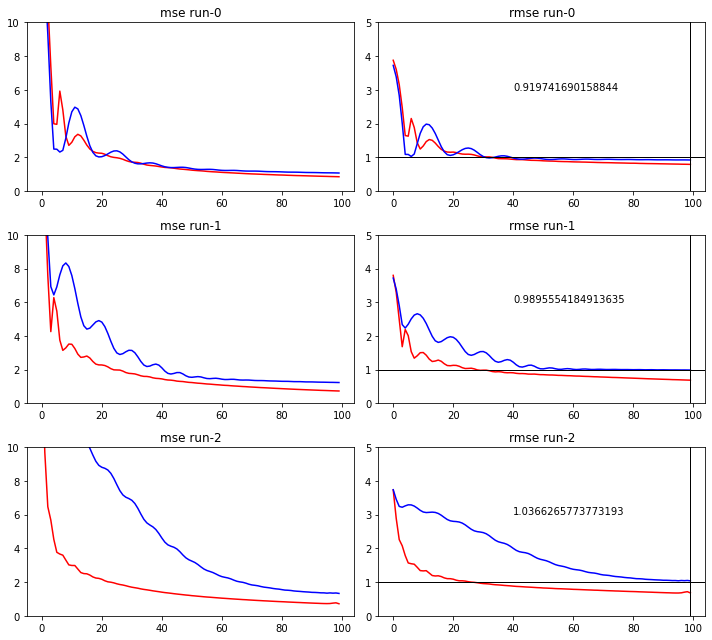

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    axs[n,1].axvline(np.where(run_history[key]['output'].history['val_root_mean_squared_error']==np.min(run_history[key]['output'].history['val_root_mean_squared_error'])), 
                     color='k', lw=1)
    axs[n,1].annotate(str(np.min(run_history[key]['output'].history['val_root_mean_squared_error'])),
                        xy=(40,3),)
    
#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')
    
    axs[n,0].set_title("mse {}".format(key))
    axs[n,1].set_title("rmse {}".format(key))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
    axs[n, 1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [15]:
models

In [16]:
output2 = models[0].fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.8420 - root_mean_squared_error: 0.7881 - val_loss: 1.0635 - val_root_mean_squared_error: 0.9188
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.8377 - root_mean_squared_error: 0.7863 - val_loss: 1.0621 - val_root_mean_squared_error: 0.9190
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.8339 - root_mean_squared_error: 0.7850 - val_loss: 1.0620 - val_root_mean_squared_error: 0.9198
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.8288 - root_mean_squared_error: 0.7828 - val_loss: 1.0601 - val_root_mean_squared_error: 0.9196
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.8263 - root_mean_squared_error: 0.7822 - val_loss: 1.0559 - val_root_mean_squared_error: 0.9181
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.8218 - root_mean_squared_error: 0.7803 - val_loss: 1.0517 - val_root_mean_squared_error:

1/1 [==============================] - 1s 1s/step - loss: 0.7054 - root_mean_squared_error: 0.7295 - val_loss: 0.9891 - val_root_mean_squared_error: 0.9036
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 0.7038 - root_mean_squared_error: 0.7288 - val_loss: 0.9883 - val_root_mean_squared_error: 0.9035
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 0.7016 - root_mean_squared_error: 0.7277 - val_loss: 0.9877 - val_root_mean_squared_error: 0.9035
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 0.7000 - root_mean_squared_error: 0.7270 - val_loss: 0.9872 - val_root_mean_squared_error: 0.9035
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 0.6972 - root_mean_squared_error: 0.7255 - val_loss: 0.9866 - val_root_mean_squared_error: 0.9035
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 0.6952 - root_mean_squared_error: 0.7245 - val_loss: 0.9860 - val_root_mean_squared_error: 0.9034

1/1 [==============================] - 1s 1s/step - loss: 0.6157 - root_mean_squared_error: 0.6819 - val_loss: 0.9934 - val_root_mean_squared_error: 0.9182
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 0.6136 - root_mean_squared_error: 0.6806 - val_loss: 0.9942 - val_root_mean_squared_error: 0.9188
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 0.6120 - root_mean_squared_error: 0.6797 - val_loss: 0.9952 - val_root_mean_squared_error: 0.9195
Epoch 100/100
1/1 [==============================] - 2s 2s/step - loss: 0.6102 - root_mean_squared_error: 0.6787 - val_loss: 0.9959 - val_root_mean_squared_error: 0.9201


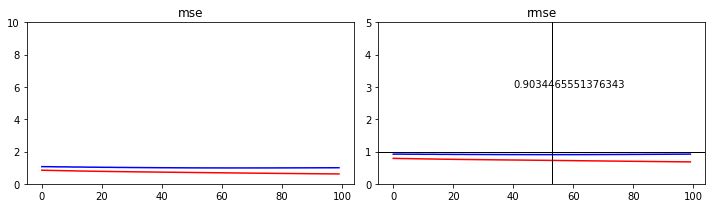

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))


axs[0].plot(output2.history['loss'], color='r')
axs[0].plot(output2.history['val_loss'], color='b')

axs[1].plot(output2.history['root_mean_squared_error'], color='r')
axs[1].plot(output2.history['val_root_mean_squared_error'], color='b')
axs[1].axvline(np.where(output2.history['val_root_mean_squared_error']==np.min(output2.history['val_root_mean_squared_error'])), 
                 color='k', lw=1)
axs[1].annotate(str(np.min(output2.history['val_root_mean_squared_error'])),
                    xy=(40,3),)

#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')

axs[0].set_title("mse")
axs[1].set_title("rmse")

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,5)

axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [ ]:
print(run_history['run-0'])
print(run_history['run-1'])
# print(run_history['run-2'])
# print(run_history['run-3'])
# print(run_history['run-6'])

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

colors = ['red', 'blue', 'green']
for n, key in enumerate(['run-0', 'run-3', 'run-6']):
    
    ax.plot(run_history[key]['output'].history['val_root_mean_squared_error'], color=colors[n], alpha=.8, lw=2)

ax.set_ylim(0,5)
plt.show()

In [ ]:
X_train

In [ ]:
X_train.groupby('user').count().sort_values(by='movie',ascending=False).head()

In [ ]:
user = 31060
ratings[ratings.user==user]

In [ ]:
movie_array = ratings[ratings.user==user].movie.values.astype(int)
user = np.array([int(user) for n in range(len(movie_array))])

In [ ]:
pred = model.predict([movie_array, user])

In [ ]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        elif pair[1] == 1:
            val.append(pair[1] + 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return sum(val) / len(pred.flatten())

In [ ]:
pred

In [ ]:
sns.histplot(pred.flatten(), bins=5)
plt.show()

In [ ]:
is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values)

In [ ]:
stats = []
for u in X_train.user.unique():
    movie_array = ratings[ratings.user==u].movie.values.astype(int)
    user_array = np.array([int(u) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    
    acc = is_close_enough(np.round(pred.flatten(), 1), X_train[X_train.user==u].rating_score.values)
    
    stats.append((u, acc, len(movie_array), np.mean(X_train[X_train.user==u].rating_score.values)))

In [ ]:
len(stats)

In [ ]:
stats[-1]

In [ ]:
stats_df = pd.DataFrame(stats, columns=['user', 'accuracy', 'n_ratings', 'mean_rating'])
stats_df

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=stats_df, x='mean_rating', y='accuracy')

plt.show()

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=stats_df, x='n_ratings', y='accuracy')

plt.show()

In [ ]:
sns.histplot(data=stats_df, x='accuracy')

plt.show()